In [1]:
!pip install torchsummary

In [2]:
!pip install facenet_pytorch

In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image
from tqdm import tqdm

In [3]:
from pathlib import Path
ROOT_PATH = Path('leapGestRecog')

In [4]:
ds = ImageFolder(ROOT_PATH/'01')
CLASSES = ds.classes
CLASSES

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [42]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3), # Pictures black and white
                         tt.Resize([128, 128]),
                         # Settings for expanding the dataset
                         tt.RandomHorizontalFlip(),           # Random 90 degree rotations
                         tt.RandomRotation(30),               # Random 30 degree rotations
#                          tt.ToTensor(),                       # Cast to tensor
                         ])                      

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
#                         tt.ToTensor(),
                        ])
     

In [78]:
def create_df(path):
               
        ds = pd.DataFrame(columns=['Class', 'Path'])
        persons = [entry.name for entry in os.scandir(path)]
        
        for person in tqdm(persons):
            current_class_path = ROOT_PATH / Path(person)
            for current_class in os.scandir(current_class_path):
                for pic_name in os.scandir(Path(current_class)):
                    data = pd.DataFrame({'Class': [current_class.name], 'Path': [str(Path(pic_name))]})
                    ds = pd.concat(objs=[data, ds], axis=0)
        return ds

class GestureDataset(Dataset):
    
    def __init__(self, dataframe: pd.DataFrame, label2indx,
                 transformer, img_column: str = 'Path', label_column: str = 'Class'):
        super().__init__()
        self.transformer = transformer
        self.dataframe = dataframe
        self.img_column = img_column
        self.label_column = label_column
        self.label2indx = label2indx
        self.indx2label = {indx: label for label, indx in self.label2indx.items()}

        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, indx):
        image = cv2.imread(self.dataframe.iloc[indx][self.img_column])
        image = image / 255
        image = image.astype('float32')
        image = torch.from_numpy(image).permute(2, 0, 1)

        label = self.dataframe.iloc[indx][self.label_column]
        
        if self.transformer:
            sample = self.transformer(image)
        
        return sample, self.label2indx[label]

In [43]:
from sklearn.model_selection import train_test_split

df = create_df(ROOT_PATH)
train_df, valid_df = train_test_split(df, test_size=0.25, shuffle=True, random_state=13, stratify=df['Class'])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.84s/it]


In [79]:
LABEL2INDX = {label: int(label.split('_')[0]) - 1 for label in df['Class'].unique()}

train_ds = GestureDataset(dataframe=train_df, transformer=train_tfms, label2indx=LABEL2INDX)
valid_ds = GestureDataset(dataframe=valid_df, transformer=test_tfms, label2indx=LABEL2INDX)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)

In [45]:
len(train_ds), len(valid_ds)

(15000, 5000)

In [5]:
def digit_to_classname(digit):
    for idx, itm in enumerate(CLASSES):
        if idx == digit:
            return itm

torch.Size([3, 128, 128])
tensor(3) 04_fist_moved


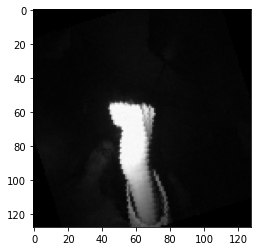

In [62]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0)) #, cmap='gray')
    break

In [63]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 128, 128])


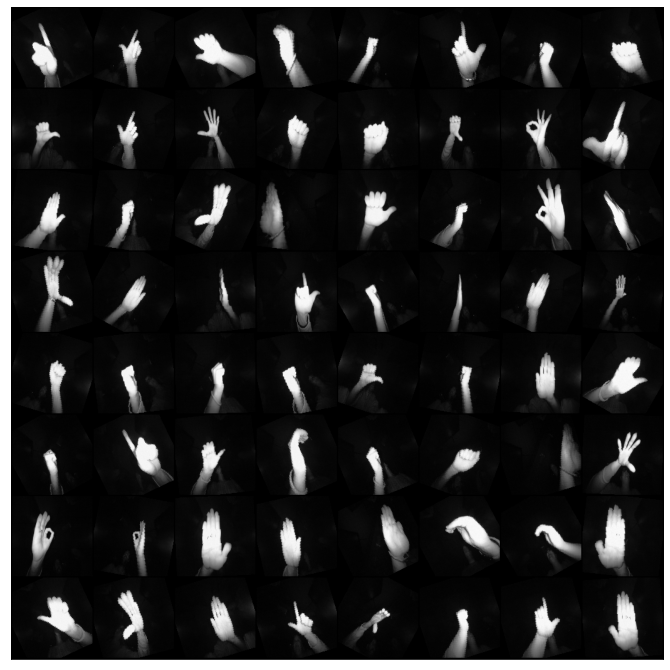

In [64]:
show_batch(train_dl)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 128, 128))

C:\Users\Alina\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Alina\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [68]:
for param in resnet.parameters():
    param.requires_grad = False

in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(CLASSES))
resnet.fc = fc

params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

In [80]:
from time import time

def train(model,
          criterion,
          optimizer,
          train_dl,
          valid_dl,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dl):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dl)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in valid_dl:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(valid_dl):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses


print_every = 50
num_epoch = 10

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    print_every=print_every,
    num_epoch=num_epoch
)



Epoch [1]/[10]. Batch [50]/[235]. Train loss 1.361. Train acc 59.594. Val loss 1.426. Val acc 50.200. Took 109.949 seconds
Epoch [1]/[10]. Batch [100]/[235]. Train loss 1.111. Train acc 67.141. Val loss 0.832. Val acc 77.220. Took 111.156 seconds
Epoch [1]/[10]. Batch [150]/[235]. Train loss 0.928. Train acc 72.688. Val loss 0.702. Val acc 79.200. Took 110.034 seconds
Epoch [1]/[10]. Batch [200]/[235]. Train loss 0.804. Train acc 76.680. Val loss 0.617. Val acc 80.020. Took 110.033 seconds
Epoch took 474.5948462486267
Epoch [2]/[10]. Batch [15]/[235]. Train loss 0.040. Train acc 78.438. Val loss 0.642. Val acc 79.140. Took 75.906 seconds
Epoch [2]/[10]. Batch [65]/[235]. Train loss 0.099. Train acc 85.769. Val loss 0.562. Val acc 82.980. Took 109.345 seconds
Epoch [2]/[10]. Batch [115]/[235]. Train loss 0.135. Train acc 87.663. Val loss 0.510. Val acc 83.700. Took 109.437 seconds
Epoch [2]/[10]. Batch [165]/[235]. Train loss 0.162. Train acc 88.163. Val loss 0.487. Val acc 84.240. Took

In [81]:
torch.save(resnet, 'my_model')

In [82]:
resnet = torch.load('my_model')

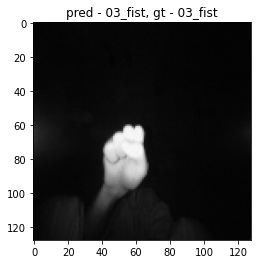

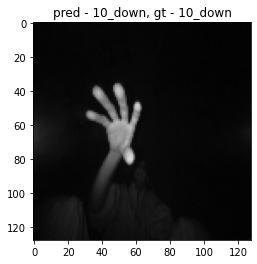

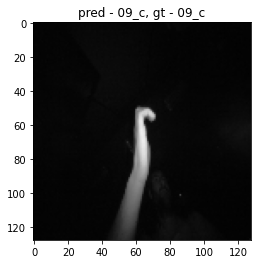

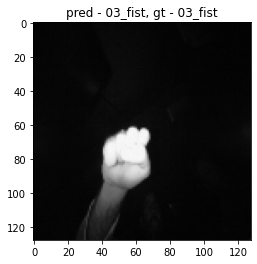

In [83]:
with torch.no_grad():
    for i, data in enumerate(valid_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = resnet(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>5:
            break

In [6]:
from facenet_pytorch import MTCNN

class FaceGestDetector(object):
    """
    Face and gesture detector class
    """

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.emodel = torch.load('my_model')
        self.emodel.eval()

    def _draw(self, frame, boxes, probs, landmarks):
        """
        Draw landmarks and boxes for each face detected
        """
        try:
            for bbox, prob, ld in zip(boxes, probs, landmarks):
#                 print(bbox[0], bbox[1], bbox[2], bbox[3])
                pt1 = (int(bbox[0]), int(bbox[1]))
                pt2 = (int(bbox[2]), int(bbox[3]))
                # Draw rectangle on frame
                cv2.rectangle(frame,
                              pt1=pt1,
                              pt2=pt2,
                              color=(0, 0, 255),
                              thickness=2)

                # Show probability
                cv2.putText(frame, 
                     str(prob), pt2, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

  
        except Exception as e:
            print(e)
            pass

        return frame

    def run(self):
        """
            Run the FaceGestDetector and draw boxes around detected faces
        """                
        cap = cv2.VideoCapture(0)  
        while True:
            ret, frame = cap.read()
            try:
                # detect face box, probability and landmarks
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
               
                # draw on frame
                frame = self._draw(frame, boxes, probs, landmarks)

            except:
                pass

            # Show the frame
            cv2.imshow('Face and Gesture Detection', frame)

            if cv2.pollKey() != -1:
                break
            
            if (len(boxes) > 0 and probs[0] > 0.90):
                cv2.waitKey(0)
                break
        
        probs = []
        cls = -1
        prob = 0
        msg = ['Stop!', 'L for loser?', 'Hey there!', '...', 'Aces High', 
               'Check please!', 'Alrighty then!', 'Stop!', 'Catch me', 'Slow down']
        
        while True:
            ret, frame = cap.read()
            
            # detect gesture
            
            image = cv2.resize(frame, (128, 128))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = np.expand_dims(image, -1).repeat(3, -1)
            image = image / 255
            torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).to(self.device).float()
                
            with torch.no_grad():
                output = self.emodel(torch_image)
                if (len(probs) >= 25):
                    probs.pop(0)
                probs.append(output[0].cpu().numpy())
                if (len(probs) >= 25):
                    avprobs = np.average(probs, axis=0)
                    cls = avprobs.argmax()
                    prob = avprobs[cls]
                    
           
            if cls >= 0:
                  cv2.putText(frame, 
                        f'{digit_to_classname(cls)}: {msg[int(cls)]}', 
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, (255, 255, 255), 2, cv2.LINE_AA)

              
            cv2.imshow('Face and Gesture Detection', frame)
            if cv2.pollKey() != -1:
                break
                
                
        cap.release()
        cv2.destroyAllWindows()
        
        
# Run the app
mtcnn = MTCNN()
fgd = FaceGestDetector(mtcnn)

In [7]:
fgd.run()